In [76]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from imblearn.ensemble import BalancedBaggingClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import train_test_split
from itertools import permutations, product
import functools
from sklearn.metrics import accuracy_score, auc, confusion_matrix, balanced_accuracy_score, precision_recall_curve, auc, roc_curve, roc_auc_score
import tqdm
from numba import njit,jit
import numpy as np
from numpy import mean
from numpy import std
import pickle
from os import path
from sklearn.model_selection import cross_val_score
from warnings import simplefilter
from collections import OrderedDict
import matplotlib.pyplot as plt
simplefilter(action="ignore", category=pd.errors.PerformanceWarning)



In [3]:
df = pd.read_csv('virus_genome/human_infecting_virus', delimiter='\t', header=None)
df[['ID', 'DNA Sequence']] = df[0].str.split(expand=True)
df = df.drop(0, axis=1)
df['isZoonotic'] = 1


df2 = pd.read_csv('virus_genome/Other_viruses', delimiter='\t', header=None)
df2[['ID', 'DNA Sequence']] = df2[0].str.split(expand=True)
df2 = df2.drop(0, axis=1)
df2['isZoonotic'] = 0

# make both have the same amount of samples..?

thresh = len(df)
# df2.drop(df2.index[thresh:len(df2.index)], inplace=True)

dfother = pd.DataFrame()
it = len(df)+1

print(len(df))
print(len(df2))
# iterate through each sequence
for i in range(len(df2)):
    dfother.at[it, 'DNA Sequence']=df2.at[i, 'DNA Sequence']
    dfother.at[it, 'isZoonotic']=int(0)
    dfother.at[it, 'ID']=df2.at[i, 'ID']
    it+=1


mergedDf = pd.concat([df, dfother], axis=0)


1236
8192


In [4]:
def resetkmerdict(permset)->OrderedDict:
        kmerdict = OrderedDict()
        for i in permset:
            kmerdict[i]=0
        return kmerdict

def assign_kmers_to_dict(row, permset, kmer):
    kmerdict=resetkmerdict(permset)
    st = row[2] # tune for which column the sequence is in
    for j in range(len(st)-kmer+1):
        if not st[j:j+kmer] in permset: continue
        kmerdict[st[j:j+kmer]]+=1
    return kmerdict

def getTrainParams(mergedDf):
    kmer = 4
    print(mergedDf)
    s = product('acgt',repeat = kmer)
    permset = set(["".join(x) for x in list(s)])

    l = []
    
    for row in tqdm.tqdm(mergedDf.itertuples()):
        l.append(assign_kmers_to_dict(row, permset, kmer))
        

    finalkmerdict=pd.DataFrame(l)
    mergedDf.fillna(0, inplace=True)

    X = finalkmerdict
    Y = mergedDf['isZoonotic']

    print(X)
    print(Y)
    return train_test_split(X, Y, test_size=0.2, random_state=1)

In [5]:
X_train, X_test, y_train, y_test = getTrainParams(mergedDf)

zz = X_train.head()

           ID                                       DNA Sequence  isZoonotic
0       37121  cttttaacaatcatagttttataaaagggtgtaaccgaagcggttt...         1.0
1      129724  atactttacaattatcttgtaaaaagtagggtgtaaccgaaaaggg...         1.0
2       59303  atggcggacgtgtgacatcaccgttcgctctttctaggatcctttg...         1.0
3      120686  ttgttctacttcttactcattattataaattataatgtttgtataa...         1.0
4       99565  gtgaatgatgatggcgtcgaaagacgtcgttgcagctactgctgct...         1.0
...       ...                                                ...         ...
9424   268315  ggatccacagaactccttgtatgtacagccgcgggtacccacagca...         0.0
9425   130329  ctcatgtcattaataagaccatgcagaaaatgcaaatgaggcgaag...         0.0
9426  1239437  ccgaagtgggatggcggctgccgccgcttcggcgcttggcgcttcg...         0.0
9427   358812  gtatacgaggttagttcattctcgtatacacgattggacaaatcaa...         0.0
9428    11287  atggaaggaggaattcgtgcagcgttttcaggcctgaatgatgtta...         0.0

[9428 rows x 3 columns]


9428it [01:38, 95.97it/s] 


      gcct  ggac  gaca  accg  gata  aaag  tact  tgtg  cccc  tgct  ...  gggg  \
0       20    26    43     8    35    35    48    68    18    34  ...    19   
1       27    34    50     9    33    49    51    85    16    38  ...    26   
2       41    53    79    76    30    71    35    58    32    47  ...    21   
3       36    36    50    13    31    42    51   104    39    36  ...    29   
4       32    30    33     8    26    51    22    40    68    46  ...    33   
...    ...   ...   ...   ...   ...   ...   ...   ...   ...   ...  ...   ...   
9423    12    13    11     9     8     9    12    10     6     8  ...     8   
9424   103    75   111    93   136   212   137   143    50   184  ...    81   
9425    19    23    34    10    28    52    23    51     9    36  ...    21   
9426    27    65    88    23    60    95    41    54    34    54  ...    73   
9427    17    80    97    29    30    73    26    40    55    31  ...    87   

      ttcg  gtgc  cgcg  taca  ctta  tgat  atca  aga

In [6]:
model = LogisticRegression(
    multi_class="multinomial", max_iter=1000,
    fit_intercept=False, tol=0.001, solver='saga', random_state=42)
model.fit(X_train, y_train)

LogisticRegression(fit_intercept=False, max_iter=1000,
                   multi_class='multinomial', random_state=42, solver='saga',
                   tol=0.001)

In [7]:
# all 0s for some reason
print(X_test[:10])
predictions = model.predict(X_test)
print(accuracy_score(y_test, predictions))

      gcct  ggac  gaca  accg  gata  aaag  tact  tgtg  cccc  tgct  ...  gggg  \
1302     6     4     4     8    10     9    17    14    15    13  ...     7   
6596     8     9    35    12    66    46    46    26     5    30  ...     8   
4095     9     6     6     2    12    16    14    19    12    16  ...     5   
7284   366   247   631   488   872   774   532   397   117   785  ...   147   
4899    17    28    30    23    52    65    74    33    38   117  ...     2   
6289    22    53    80    12    46    89    33    44    19    51  ...    26   
7830   169   261   227   502    31    36    38   106   172   125  ...   163   
2048   232   315   197   447    60    82    73   101   314   184  ...   221   
7122    62    33   125    32   227   322   271   187    27   201  ...    28   
7488    10     3     4     6     8    17     4     5    12     6  ...    12   

      ttcg  gtgc  cgcg  taca  ctta  tgat  atca  agac  taag  
1302    12     9     7    12     5    22     8     4    13  
6596    

In [8]:
knntest = BalancedBaggingClassifier(base_estimator=KNeighborsClassifier(n_neighbors = 1, n_jobs = 1), n_estimators = 10, n_jobs = 1)

knntest.fit(X_train, y_train)
# knn = KNeighborsClassifier(n_neighbors=5)

BalancedBaggingClassifier(base_estimator=KNeighborsClassifier(n_jobs=1,
                                                              n_neighbors=1),
                          n_jobs=1)

In [9]:
predictions = knntest.predict(X_test)
print(predictions[:10])
print(accuracy_score(y_test, predictions))

[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
0.9204665959703076


In [52]:

randforest = BalancedBaggingClassifier(base_estimator=DecisionTreeClassifier(max_features="sqrt"))

randforest.fit(X_train, y_train)

BalancedBaggingClassifier(base_estimator=DecisionTreeClassifier(max_features='sqrt'))

In [37]:
def saveModel(model, name, X_test, y_test, params=None, dir='curr_models', gradBoost=False):
    predictions = model.predict(X_test)
    currAcc = accuracy_score(y_test, predictions)
    
    print(confusion_matrix(y_test, predictions))
    
    if not path.exists(f"{dir}/{name}.pkl"):
        print("does not exist")

        pickle.dump(model, open(f'{dir}/{name}.pkl', 'wb'))
    else:
        pickled_model = pickle.load(open(f'{dir}/{name}.pkl', 'rb'))
        if gradBoost:
            cols_when_model_builds = model.get_booster().feature_names
            X_test=X_test[cols_when_model_builds]
        
        picklePredictions=pickled_model.predict(X_test)
        pickleAcc=accuracy_score(y_test, picklePredictions)
        
        if currAcc > pickleAcc:
            print("update!")
            print(confusion_matrix(y_test, picklePredictions))

            print("curr", currAcc, "pickle", pickleAcc)
            pickle.dump(model, open(f'{dir}/{name}.pkl', 'wb'))

            if params != None:
                pickle.dump(params, open(f'{dir}/{name}-params.pkl', 'wb'))
        else:
            model=pickled_model
    return model

In [53]:
saveModel(randforest, "randforest", X_test, y_test)

predictions = randforest.predict(X_test)
print(accuracy_score(y_test, predictions))

# for i in range(1000):
#     predictions[i] != y_test_list[i] and print(predictions[i], "vs", y_test_list[i])

[[1551   83]
 [  37  215]]
update!
[[1552   82]
 [  44  208]]
curr 0.936373276776246 pickle 0.9331919406150583
0.936373276776246


In [54]:
probability_predictions = randforest.predict_proba(X_test)
preds = randforest.predict(X_test)
print(accuracy_score(y_test, preds))


0.936373276776246


In [33]:
lr_list = [0.05, 0.075, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65,0.7, 0.75, 0.8, 0.85, 1]

parameters={
   "n_estimators":100, # 200 kind of overfits I think
    "max_features":2,
    "max_depth":6,
    "random_state":0,
    "min_sample_split":50,
    "subsample":0.8,
    "warm_start":True
}



for learning_rate in lr_list:
    gradBoost = GradientBoostingClassifier(n_estimators=parameters['n_estimators'], 
    learning_rate=learning_rate, max_features=parameters['max_features'], 
    max_depth=parameters['max_depth'], random_state=parameters['random_state'], 
    min_samples_split=parameters['min_sample_split'], subsample=parameters['subsample'], 
    warm_start=parameters['warm_start'])

    parameters['learning_rate']=learning_rate
    gradBoost.fit(X_train, y_train)

    testingAcc = accuracy_score(y_test, gradBoost.predict(X_test))
    trainingAcc = accuracy_score(y_train, gradBoost.predict(X_train))
    
    print("Learning rate: ", learning_rate)
    # print("Accuracy score (training): {0:.3f}".format(trainingAcc))
    print("Accuracy score (validation): {0:.3f}".format(testingAcc))
    # print(f"Feature importance {gradBoost.feature_importances_}")

    # pickle.dump(gradBoost, open('gradBoost.pkl', 'wb'))
    saveModel(gradBoost, "gradBoost", X_test, y_test, parameters)

Learning rate:  0.05
Accuracy score (validation): 0.955
[[1621   13]
 [  71  181]]
update!
[[1607   27]
 [ 251    1]]
curr 0.9554612937433722 pickle 0.8525980911983033


/Users/benjaminli/opt/miniconda3/envs/seq/lib/python3.8/site-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)


Learning rate:  0.075
Accuracy score (validation): 0.957
[[1621   13]
 [  68  184]]
update!
[[1621   13]
 [  71  181]]
curr 0.957051961823966 pickle 0.9554612937433722
Learning rate:  0.1
Accuracy score (validation): 0.960
[[1619   15]
 [  60  192]]
update!
[[1621   13]
 [  68  184]]
curr 0.9602332979851538 pickle 0.957051961823966
Learning rate:  0.15
Accuracy score (validation): 0.959
[[1618   16]
 [  62  190]]
Learning rate:  0.2
Accuracy score (validation): 0.961
[[1617   17]
 [  56  196]]
update!
[[1619   15]
 [  60  192]]
curr 0.9612937433722163 pickle 0.9602332979851538
Learning rate:  0.25
Accuracy score (validation): 0.958
[[1613   21]
 [  59  193]]
Learning rate:  0.3
Accuracy score (validation): 0.958
[[1610   24]
 [  56  196]]
Learning rate:  0.35
Accuracy score (validation): 0.954
[[1604   30]
 [  57  195]]
Learning rate:  0.4
Accuracy score (validation): 0.960
[[1614   20]
 [  55  197]]
Learning rate:  0.45
Accuracy score (validation): 0.955
[[1608   26]
 [  58  194]]
Lea

In [39]:
lr_list = [0.05, 0.075, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65,0.7, 0.75, 0.8, 0.85, 1]

parameters={
   "n_estimators":100, # 200 kind of overfits I think
    "max_features":2,
    "max_depth":6,
    "random_state":0,
    "min_sample_split":50,
    "subsample":0.8,
    "warm_start":True
}



for learning_rate in lr_list:
    xgBoost = XGBClassifier(n_estimators=parameters['n_estimators'], 
    learning_rate=learning_rate, 
    max_depth=parameters['max_depth'], random_state=parameters['random_state'], 
    subsample=parameters['subsample'], 
    )

    parameters['learning_rate']=learning_rate
    xgBoost.fit(X_train, y_train)

    testingAcc = accuracy_score(y_test, xgBoost.predict(X_test))
    trainingAcc = accuracy_score(y_train, xgBoost.predict(X_train))
    
    print("Learning rate: ", learning_rate)
    # print("Accuracy score (training): {0:.3f}".format(trainingAcc))
    print("Accuracy score (validation): {0:.3f}".format(testingAcc))
    # print(f"Feature importance {gradBoost.feature_importances_}")

    # pickle.dump(gradBoost, open('gradBoost.pkl', 'wb'))
    saveModel(xgBoost, "xgBoost", X_test, y_test, parameters)

Learning rate:  0.05
Accuracy score (validation): 0.959
[[1623   11]
 [  67  185]]


ValueError: feature_names mismatch: ['attg', 'gata', 'tcgg', 'aacc', 'ctcc', 'ttac', 'cata', 'taac', 'tgcc', 'ttca', 'ttaa', 'aggc', 'ttgg', 'tcca', 'catg', 'cgtc', 'gcgg', 'agcg', 'ctaa', 'aatc', 'ctcg', 'atcg', 'taga', 'tgag', 'cgca', 'tgcg', 'catt', 'aacg', 'gttc', 'tgga', 'ttgt', 'gaca', 'aaaa', 'aatg', 'tttc', 'cgtg', 'cacg', 'tatc', 'gaga', 'tcgt', 'ataa', 'agac', 'ctga', 'ggca', 'ggcg', 'cccc', 'ccat', 'cttc', 'ccga', 'gacg', 'aaca', 'acga', 'ccta', 'tgta', 'ggaa', 'ggta', 'gact', 'gcgc', 'tggt', 'atta', 'ttag', 'agct', 'ggct', 'atcc', 'caaa', 'acaa', 'tatg', 'tcgc', 'agga', 'atct', 'tcct', 'gggt', 'cggc', 'cact', 'tgtc', 'agta', 'tcat', 'ccgt', 'tgat', 'atgg', 'aagt', 'ttct', 'ctac', 'tgca', 'ggga', 'tcga', 'ctgt', 'acac', 'caac', 'tact', 'ctag', 'tcag', 'aata', 'ccca', 'ctat', 'ccgc', 'cgta', 'gtta', 'cgag', 'gggg', 'gcgt', 'acct', 'ggtg', 'actt', 'atca', 'cgcg', 'gtgc', 'tagg', 'taaa', 'taca', 'cccg', 'tagt', 'caga', 'tgaa', 'ctct', 'cttg', 'gcta', 'caag', 'agca', 'tgac', 'tggc', 'tgct', 'cttt', 'aatt', 'gctg', 'cggt', 'taag', 'cgcc', 'gttg', 'ccag', 'gcag', 'gccc', 'ggtt', 'tgtg', 'aagg', 'gacc', 'gcga', 'tacc', 'tgtt', 'cgaa', 'ttga', 'atat', 'aaac', 'cgct', 'ccac', 'gtcc', 'gtag', 'ctgc', 'ggtc', 'aggg', 'ccct', 'cgac', 'gagg', 'gtat', 'cagt', 'atac', 'ttcg', 'gtca', 'acgg', 'tctg', 'cctt', 'acgc', 'agtc', 'gaac', 'gcat', 'gctt', 'gttt', 'gcac', 'gtct', 'attc', 'cctc', 'aact', 'actc', 'attt', 'cctg', 'taat', 'ctta', 'ggat', 'acag', 'gaat', 'tatt', 'gatc', 'tctt', 'gtga', 'gagc', 'aagc', 'aggt', 'tcac', 'atgc', 'gtgg', 'acat', 'ttta', 'tagc', 'aaat', 'agaa', 'atga', 'agcc', 'cagc', 'cgga', 'cagg', 'aaga', 'accg', 'ccaa', 'cggg', 'ctgg', 'gaag', 'gctc', 'tggg', 'caat', 'ccgg', 'gaaa', 'caca', 'ggag', 'acca', 'ggcc', 'tacg', 'tata', 'ttcc', 'cgtt', 'gtgt', 'accc', 'agtt', 'gatt', 'tcaa', 'gcaa', 'aaag', 'acta', 'atag', 'agag', 'cacc', 'catc', 'gatg', 'agtg', 'atgt', 'actg', 'cgat', 'tttt', 'tctc', 'ttat', 'gtcg', 'gtac', 'gccg', 'gagt', 'agat', 'ttgc', 'tttg', 'gcca', 'acgt', 'gggc', 'ctca', 'tcta', 'gtaa', 'tccg', 'tccc', 'ggac', 'gcct'] ['gcct', 'ggac', 'gaca', 'accg', 'gata', 'aaag', 'tact', 'tgtg', 'cccc', 'tgct', 'agaa', 'caat', 'cgga', 'ggct', 'tttt', 'tgag', 'actc', 'gtcc', 'cccg', 'tgcc', 'gtcg', 'gctc', 'tcgt', 'aaat', 'catc', 'acta', 'ttca', 'ccca', 'aggc', 'aatg', 'cgtt', 'gttc', 'ccaa', 'ccgc', 'tatc', 'agca', 'caac', 'aaca', 'tccg', 'gtgt', 'ggca', 'gttg', 'gccc', 'ctcc', 'gcgt', 'gctg', 'gcgg', 'ccag', 'ggaa', 'tctt', 'cttt', 'caag', 'gaac', 'tcta', 'accc', 'cgtg', 'tggt', 'ttaa', 'acga', 'acgc', 'attc', 'ggtg', 'gagc', 'tgtt', 'agag', 'cagc', 'atct', 'cact', 'cgca', 'acac', 'aata', 'cgtc', 'catt', 'aaga', 'agta', 'gatt', 'gatg', 'aact', 'atcg', 'tcac', 'ttcc', 'gact', 'actt', 'ccct', 'gtag', 'actg', 'acca', 'tggc', 'cacc', 'agcg', 'ggcc', 'tctc', 'tata', 'aagt', 'cgac', 'tgaa', 'tttg', 'tacg', 'caga', 'agtt', 'tgcg', 'aggg', 'gttt', 'gtta', 'tcag', 'ctgc', 'ggtt', 'cttg', 'gtct', 'aaaa', 'cctg', 'atac', 'ctaa', 'gcgc', 'atgg', 'tcgg', 'ctca', 'cacg', 'aggt', 'ttta', 'cgag', 'atgc', 'gtat', 'taaa', 'aacg', 'tcgc', 'ctac', 'ctag', 'ttgg', 'gacg', 'tccc', 'ccat', 'tctg', 'gaat', 'aatt', 'atgt', 'cctc', 'cggc', 'cctt', 'acgg', 'ggtc', 'ttga', 'cggg', 'acag', 'tcaa', 'taga', 'aacc', 'agga', 'taat', 'ttat', 'tgta', 'cgct', 'ggta', 'acct', 'tgga', 'taac', 'tcga', 'aatc', 'ccga', 'aagg', 'tacc', 'atga', 'tatt', 'acat', 'tagt', 'agtc', 'tcat', 'gcag', 'agct', 'caaa', 'gcat', 'tgtc', 'gcac', 'gaaa', 'cgat', 'gatc', 'atta', 'ttct', 'ataa', 'gagt', 'cttc', 'gtgg', 'agat', 'ctcg', 'gggc', 'attg', 'gtaa', 'tagc', 'cgta', 'gaag', 'acaa', 'tgca', 'ttgt', 'ccgg', 'tggg', 'gctt', 'tatg', 'ggga', 'ccta', 'agcc', 'gaga', 'gggt', 'gcaa', 'ctgg', 'ggag', 'cgaa', 'tagg', 'ggcg', 'ttac', 'gtca', 'ctgt', 'gcta', 'gacc', 'ctga', 'atag', 'ggat', 'cagg', 'gtga', 'agtg', 'tcca', 'ttgc', 'aaac', 'attt', 'acgt', 'caca', 'cata', 'gagg', 'tttc', 'gtac', 'ccgt', 'tcct', 'gcga', 'atat', 'cagt', 'tgac', 'ctat', 'gcca', 'cgcc', 'ctct', 'catg', 'cggt', 'gccg', 'ccac', 'atcc', 'ttag', 'aagc', 'gggg', 'ttcg', 'gtgc', 'cgcg', 'taca', 'ctta', 'tgat', 'atca', 'agac', 'taag']

In [55]:
# Models within "orig_models" folder have the highest training acc but not as great cross val

best_xgboost = pickle.load(open('curr_models/xgBoost.pkl', 'rb'))
best_xgboost_params = pickle.load(open('curr_models/xgBoost-params.pkl', 'rb'))

best_gradBoost = pickle.load(open('curr_models/gradBoost.pkl', 'rb'))
best_gradBoost_params = pickle.load(open('curr_models/gradBoost-params.pkl', 'rb'))

best_rF = pickle.load(open('curr_models/randforest.pkl', 'rb'))

print(best_xgboost_params)
print(best_gradBoost_params)


# print("Best XG Accuracy: ", accuracy_score(y_test, best_xgboost.predict(X_test)))
# print("Balanced XG Accuracy: ", balanced_accuracy_score(y_test, best_xgboost.predict(X_test)))

print("Best GB Accuracy: ", accuracy_score(y_test, best_gradBoost.predict(X_test)))
print("Balanced GB Accuracy: ", balanced_accuracy_score(y_test, best_gradBoost.predict(X_test)))

print("Best rF Accuracy: ", accuracy_score(y_test, best_rF.predict(X_test)))
print("Balanced rF Accuracy: ", balanced_accuracy_score(y_test, best_rF.predict(X_test)))

{'n_estimators': 100, 'max_features': 2, 'max_depth': 6, 'random_state': 0, 'min_sample_split': 50, 'subsample': 0.8, 'warm_start': True, 'learning_rate': 0.3}
{'n_estimators': 100, 'max_features': 2, 'max_depth': 6, 'random_state': 0, 'min_sample_split': 50, 'subsample': 0.8, 'warm_start': True, 'learning_rate': 0.2}
Best GB Accuracy:  0.9612937433722163
Balanced GB Accuracy:  0.883686930504556
Best rF Accuracy:  0.936373276776246
Balanced rF Accuracy:  0.9011895047696761


precision recall: 0.9062074414556323
[0.0010342  0.00087179 0.00146093 ... 0.00185672 0.03657456 0.00431838]


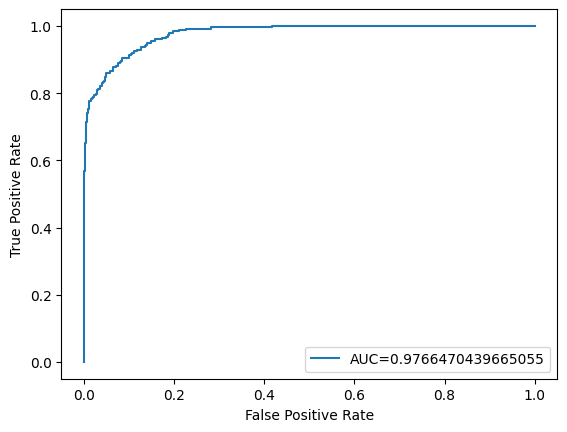

In [81]:
y_thing = y_test.to_numpy()
precision, recall, thresholds = precision_recall_curve(y_thing, best_gradBoost.predict_proba(X_test)[::,1])
aaa = auc(recall, precision)
print("precision recall: " + str(aaa))

y_pred_proba = best_gradBoost.predict_proba(X_test)[::,1]
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
auc_thing = roc_auc_score(y_test, y_pred_proba)

print(y_pred_proba)
plt.plot(fpr,tpr,label="AUC="+str(auc_thing))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()


In [57]:
y_thing = y_test.to_numpy()
precision, recall, thresholds = precision_recall_curve(y_thing, best_rF.predict(X_test))
area = auc(recall, precision)
print(area)

0.7971346764511873


In [58]:
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(best_gradBoost, X_test, y_test, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
print('Accuracy: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))

Accuracy: 0.947 (0.014)


In [59]:
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(best_rF, X_test, y_test, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
print('Accuracy: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))

Accuracy: 0.905 (0.022)
